In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
%matplotlib inline


In [2]:
yield_data = pd.read_csv('FRB_H15.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2009-11-30']


In [3]:
np.random.seed(7)
# missing_col = np.random.choice(yield_data.columns,3)
missing_col = yield_data.columns.difference(['Day of week', 'IS_WEEKEND'])
missing_col

Index(['1-month', '1-year', '10-year', '2-year', '20-year', '3-month',
       '3-year', '30-year', '5-year', '6-month', '7-year'],
      dtype='object')

In [4]:
for i in missing_col:
    yield_data[i] = \
    [d if l else np.nan for d, l in zip(yield_data[i], np.random.choice([True,False],size=yield_data.shape[0], p=[0.7,0.3]))]

In [5]:
yield_data.head()

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year,Day of week,IS_WEEKEND
2009-12-01,0.09,0.06,0.15,NaN,0.67,NaN,2.03,2.74,NaN,4.14,4.26,1,0
2009-12-02,NaN,NaN,0.15,NaN,0.72,1.19,NaN,2.8,NaN,NaN,4.26,2,0
2009-12-03,0.09,0.06,0.16,0.3,0.74,1.23,2.14,NaN,NaN,4.23,4.33,3,0
2009-12-04,NaN,0.06,0.17,NaN,0.84,1.34,2.24,NaN,3.48,NaN,4.4,4,0
2009-12-07,NaN,0.04,NaN,0.32,0.78,1.26,2.19,2.92,NaN,4.29,4.4,0,0


In [6]:
yield_data.isna().sum()

1-month        569
3-month        585
6-month        584
1-year         591
2-year         596
3-year         603
5-year         595
7-year         608
10-year        594
20-year        589
30-year        588
Day of week      0
IS_WEEKEND       0
dtype: int64

** Use [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to smooth the series(get rid of peaks in Monday and Friday). I use rolling window of 15 and power of 3 **

In [7]:
##savgol_filter polynomial filter
# yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data.iloc[:,:11]).transpose(),15,3).transpose())
# yield_data_filtered.columns = yield_data.iloc[:,:11].columns
# yield_data_filtered.index = yield_data.index
# yield_data_filtered.head()
# yield_data[yield_data.index >'2017-07-01']['1-month'].astype(np.float32).plot()
# yield_data_filtered[yield_data_filtered.index >'2017-07-01']['1-month'].astype(np.float32).plot()
yield_data_filtered = yield_data[missing_col]

**Define a rolling window function that calculate following statistic for one column:**  
1.Mean  
2.Standard Deviation  
3.Median  
4.Min  
5.Max  
6.Rooted Mean Square  
7.[Crest Factor](https://en.wikipedia.org/wiki/Crest_factor)  
8.[Zero-crossing Rate](https://en.wikipedia.org/wiki/Zero-crossing_rate)(here is Mean-crossing Rate)  
9.Trend(Slope of linear regression)

In [8]:
def rolling_method(df,col,window):
    method = ['mean','std','median','min','max']
    a = df[col].rolling(window=window, min_periods = 1)
    b = pd.concat([getattr(a,k)() for k in method],axis=1)
    b.columns  = method
    #b['RMS'] = a.apply(lambda y: np.sqrt(np.mean(y**2)))
    #b['crest'] = 0.5*(b['max']-b['min'])/b['RMS']
    #b['crossing'] = a.apply(lambda y: len(np.where(np.diff(y - np.mean(y)))[0]))/window
    #b['slope'] = a.apply(lambda y: linregress(range(window),y)[0])
    b.columns = [col + '_'+ k +'_'+str(window)+'day' 
                 for k in ['mean','std','median','min','max'#,'RMS','crest','crossing','slope'
                          ]]
    return b

In [9]:
yield_data_features=pd.concat([rolling_method(yield_data_filtered,i,j) \
                               for i in yield_data_filtered.columns[:11] \
                               for j in [3,7,15,20]],axis=1).shift(11) 
# 11 beacuse first shift 1 and then shift 10 as rolling window of 20 from 10th to 30th day
yield_data_features.head(10)


,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,7-year_mean_15day,7-year_std_15day,7-year_median_15day,7-year_min_15day,7-year_max_15day,7-year_mean_20day,7-year_std_20day,7-year_median_20day,7-year_min_20day,7-year_max_20day
2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** Append the actual yield values and apply lag **

In [10]:
yield_data_features=pd.concat([yield_data_features,yield_data],axis=1)
#yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()
for i in range(1,11):
    temp=yield_data_features[[col for col in yield_data_filtered.columns]].shift(i)
    temp.columns=[j+'_'+str(i) for j in list(temp.columns)]
    yield_data_features=pd.concat([yield_data_features,temp],axis=1)
yield_data_features = yield_data_features.fillna(method='ffill')
yield_data_features = yield_data_features[yield_data_features.index>='2010-01-14']
yield_data_features.head()

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,1-year_10,10-year_10,2-year_10,20-year_10,3-month_10,3-year_10,30-year_10,5-year_10,6-month_10,7-year_10
2010-01-14,0.020,4.355862e-10,0.020,0.02,0.02,0.0140,0.005477,0.01,0.01,0.02,...,0.45,3.8,1.09,4.54,0.05,1.65,4.61,2.61,0.19,3.34
2010-01-15,0.020,4.355862e-10,0.020,0.02,0.02,0.0160,0.005477,0.02,0.01,0.02,...,0.47,3.85,1.14,4.58,0.06,1.7,4.63,2.69,0.2,3.39
2010-01-19,0.020,4.355862e-10,0.020,0.02,0.02,0.0175,0.005000,0.02,0.01,0.02,...,0.45,3.85,1.09,4.58,0.06,1.66,4.65,2.65,0.18,3.39
2010-01-20,0.035,2.121320e-02,0.035,0.02,0.05,0.0240,0.015166,0.02,0.01,0.05,...,0.45,3.77,1.01,4.58,0.06,1.66,4.59,2.56,0.17,3.28
2010-01-21,0.040,1.414214e-02,0.040,0.03,0.05,0.0280,0.013038,0.02,0.02,0.05,...,0.4,3.85,1.01,4.63,0.06,1.6,4.59,2.6,0.15,3.33


In [11]:
yield_data_features.shape

(1929, 343)

## Apply RF and plot 

In [12]:
def predictTargetNew(target):
    print("******predicting:",target,"*******")
    Y=yield_data_features[[target]]
    X=yield_data_features.drop(target,axis=1)
    print("Shapeof Y:",Y.shape)
    print("Shapeof X:",X.shape)
    X_train=X[X.index < '2017-07-01']
    X_test=X[X.index >= '2017-07-01']
    y_train=Y[Y.index < '2017-07-01']
    y_test=Y[Y.index  >= '2017-07-01']
    print("Shapeof Y_train:",y_train.shape)
    print("Shapeof X_train:",X_train.shape)
    print("Shapeof Y_test:",y_test.shape)
    print("Shapeof X_test:",X_test.shape)
    max_depth = 30
    regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
    regr_rf.fit(X_train, y_train)
    # Predict on new data
    y_rf = pd.DataFrame(regr_rf.predict(X_test))
    y_rf.index=y_test.index
    y_rf.columns=y_test.columns
    #score
    print(target," R sq:",r2_score(y_test,y_rf))
    print(target," RMSE:",np.sqrt(mean_squared_error(y_test,y_rf)))
    final=pd.DataFrame()
    final['Time']=y_test.index
    final.index=y_test.index
    final['true']=y_test[target]
    final['pred']=y_rf[target]
    plt.figure(figsize=(8, 6))
    s = 25
    a = 0.4
    plt.figure(figsize=(8,3))
    x_axis=range(len(final))
    plt.scatter(x_axis, final['true'], edgecolor='k',
                c="navy", s=s, alpha=a, label="Data")
    plt.scatter(x_axis, final['pred'], edgecolor='k',
                c="c", s=s, alpha=a,
                label="RF (R2score={:.2f} \n RMSE={:.2f})".format(regr_rf.score(X_test, y_test),np.sqrt(mean_squared_error(y_test,y_rf))))
    plt.xticks(x_axis, final['Time'].dt.date, rotation='vertical')
    plt.xlabel("date")
    plt.ylabel(target+" yield")
    plt.gca().margins(x=0)
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

******predicting: 1-month *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1-month  R sq: -8.77742667051
1-month  RMSE: 0.147228677007


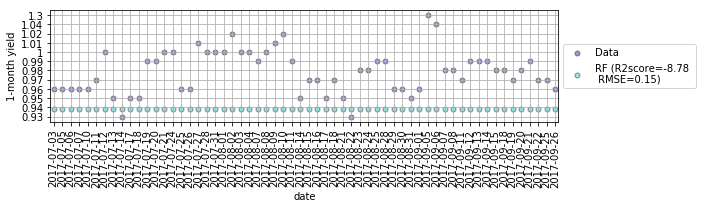

******predicting: 3-month *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3-month  R sq: -2.30332779492
3-month  RMSE: 0.0761493050964


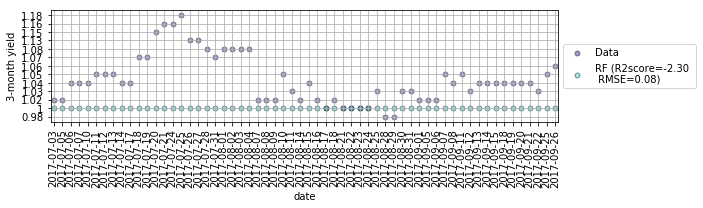

******predicting: 6-month *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


6-month  R sq: -0.554383133259
6-month  RMSE: 0.0358336434095


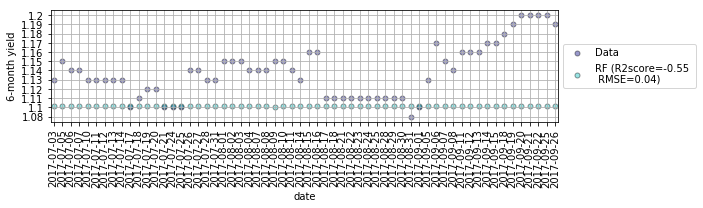

******predicting: 1-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1-year  R sq: -0.174057020887
1-year  RMSE: 0.0327037204815


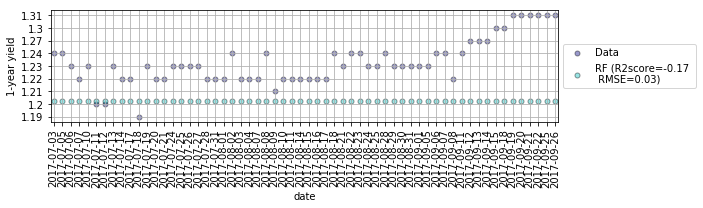

******predicting: 2-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2-year  R sq: 0.0599765581908
2-year  RMSE: 0.0389217163034


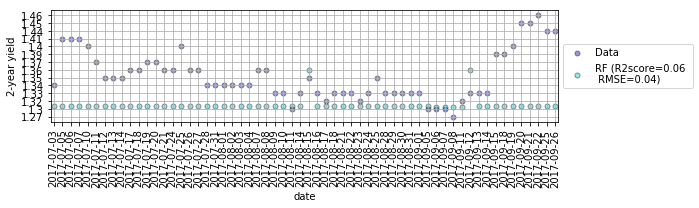

******predicting: 3-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3-year  R sq: 0.716402349891
3-year  RMSE: 0.0292722849581


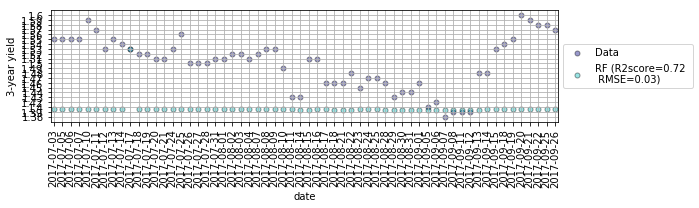

******predicting: 5-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


5-year  R sq: 0.727055024889
5-year  RMSE: 0.0390076915492


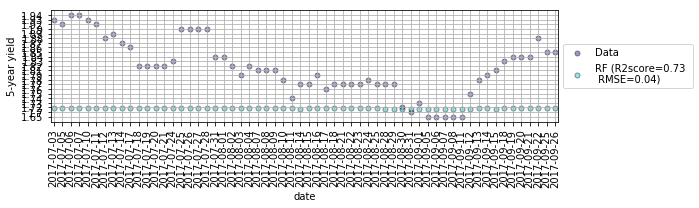

******predicting: 7-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


7-year  R sq: 0.800288870595
7-year  RMSE: 0.0335464851611


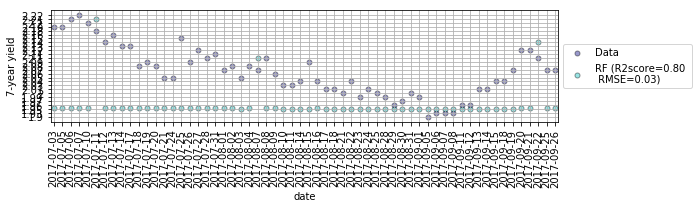

******predicting: 10-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


10-year  R sq: 0.862291225782
10-year  RMSE: 0.0309224837295


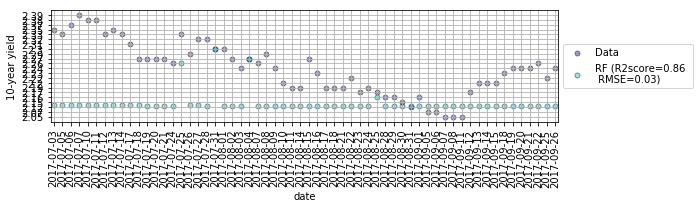

******predicting: 20-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


20-year  R sq: 0.80558031193
20-year  RMSE: 0.0326573115856


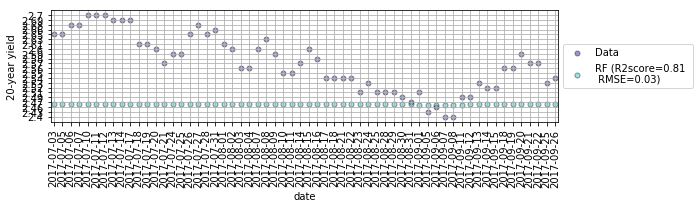

******predicting: 30-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


30-year  R sq: 0.657972284321
30-year  RMSE: 0.0384018228734


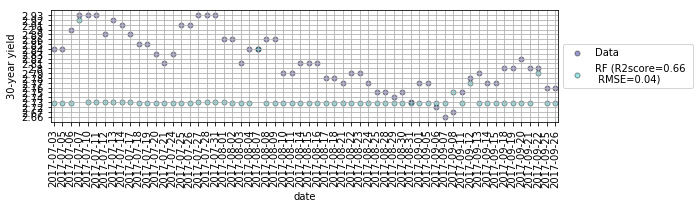

In [13]:
for target in ['1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year','7-year', '10-year', '20-year', '30-year']:
    predictTargetNew(target)